In [256]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [7]:
import pandas as pd
import os 
import matplotlib.pyplot as plt 
import re
import numpy as np
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
# For bokeh visualisations
from bokeh.plotting import figure
from bokeh.models.widgets import Panel, Tabs
from bokeh.io import show, output_notebook, reset_output
from bokeh.models import ColumnDataSource, HoverTool, Legend
from bokeh.layouts import row

In [10]:
# load tree data 
df = pd.read_csv("data/df_tree.csv")
df.id = df.id.astype("category")

# load district size 
df_size = pd.read_excel('raw_data/2022426114414371694040KKAREAL.xlsx', header=2, usecols = "B:K")
df_size = (df_size.dropna()).transpose()
df_size = df_size.reset_index()
df_size.rename(columns = {"index":'district', 0:'area_m2'}, inplace = True)
df_size['district'] = df_size['district'].str.replace("Bydel - ", "")
df_size['district'] = df_size['district'].str.replace("/", "-")
df_size['district'] = df_size['district'].str.replace("Kgs", "Kongens")
df_size['area_km2'] = df_size['area_m2']/(1000*1000)
df_size.to_csv('data/df_size.csv', index=False)

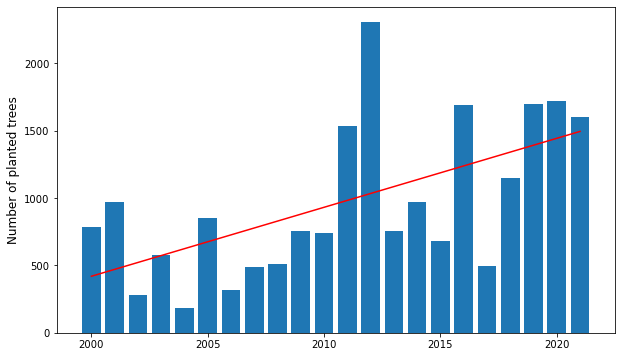

In [6]:
# Er der blevet plantet flere træer i Kbh siden 2000?
from scipy import stats
df_year = df.groupby(['year']).size()
# for trend curve
slope, intercept, r_value, p_value, std_err = stats.linregress(df_year.index.to_list(),df_year.values)

plt.figure(figsize=(10,6))
plt.bar(df_year.index,df_year.values)
plt.plot(df_year.index, slope*(df_year.index) + intercept, 'r-')
plt.ylabel('Number of planted trees',fontsize=12)
plt.show()

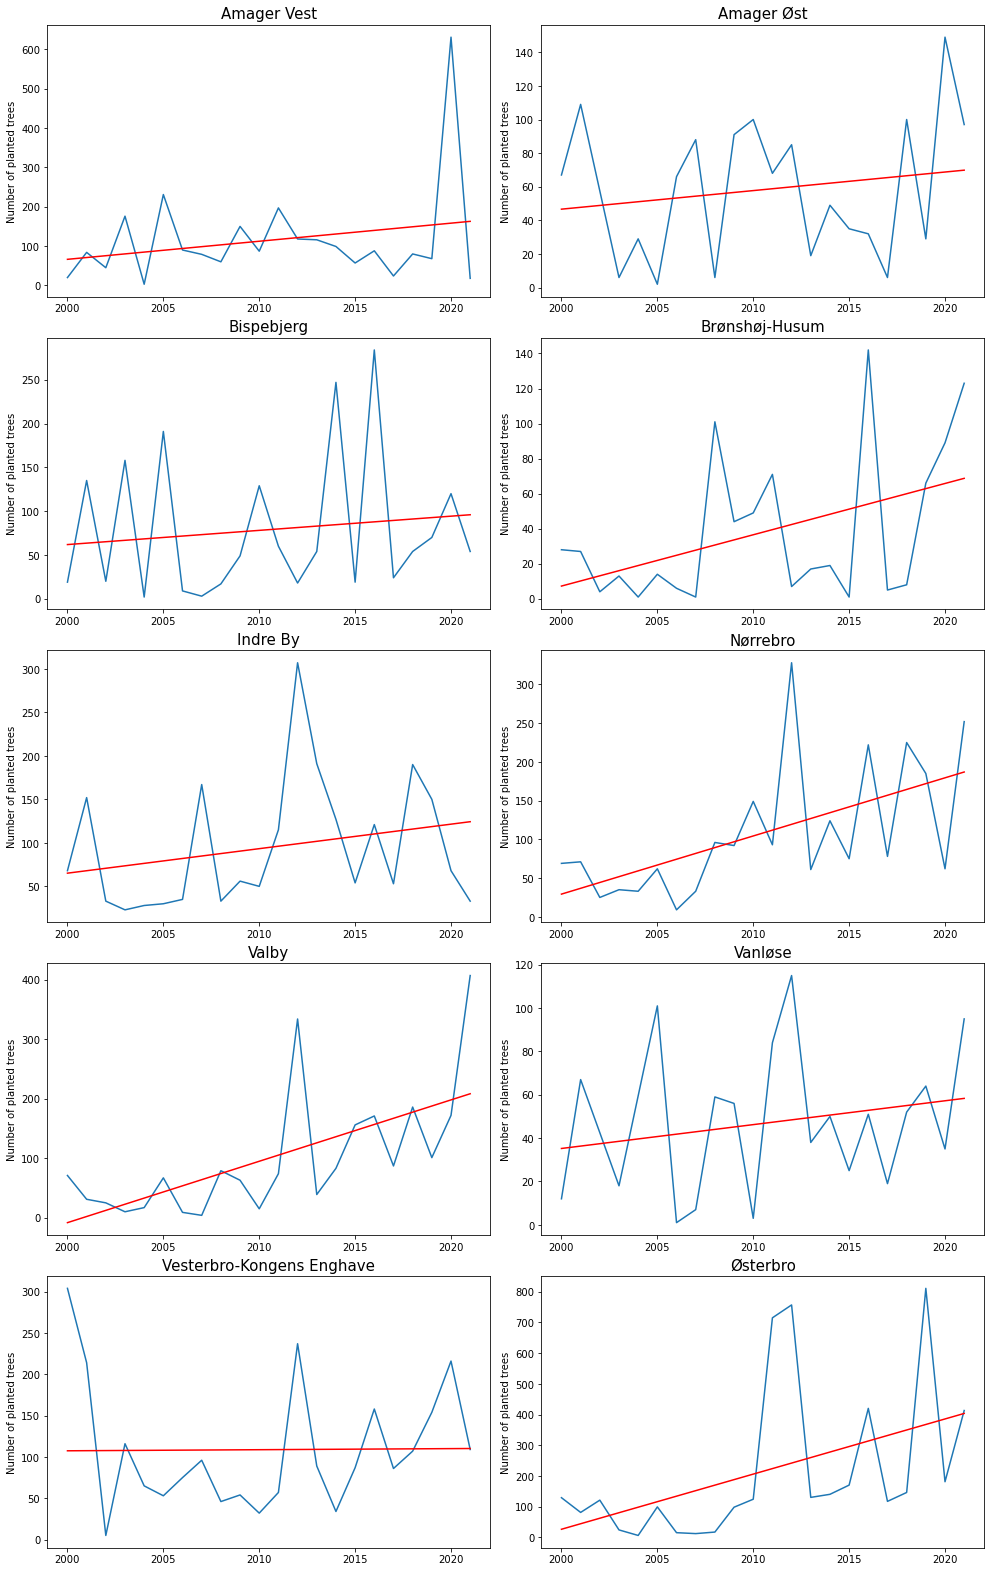

In [260]:
# Er der blevet plantet flere træer i de enkelte distrikter siden 2000?

# Bar plot of planted trees over the years in the different districts
df_districts = df.groupby(["year", "district"]).size().reset_index()
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5,2,figsize=(14,22))
figure.tight_layout(pad=2.0)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
districts = df_districts.district.unique()
for (ax, dist) in zip(axes, districts):
    temp = df_districts[df_districts["district"] == dist]
    slope, intercept, r_value, p_value, std_err = stats.linregress(temp['year'],temp[0])
    ax.plot(temp['year'],temp[0])
    ax.plot(temp['year'], slope*(temp['year']) + intercept, 'r-')
    ax.set_ylabel('Number of planted trees')
    ax.set_title(dist, fontsize=15)

In [261]:
# # Plot district sizes
# plt.figure()
# df_size = df_size.sort_values(by='area_km2',ascending=False)
# plt.xticks(rotation=90)
# plt.bar(df_size['district'],df_size['area_km2'])
# plt.show()

# How many trees in relation to area size 
df_rank = pd.DataFrame(index=df_districts.district.unique(),columns=['area_km2','tree_per_km2'])
for dist in districts:
    temp = df_districts[df_districts['year'] >= 2018]
    temp = temp[temp['district']==dist]
    area = (df_size[df_size['district']==dist]).area_km2
    df_rank.loc[dist,'area_km2'] = float(area)
    df_rank.loc[dist,'tree_per_km2'] = sum(temp[0])/float(area)
df_rank.sort_values(by='tree_per_km2',ascending=False)

,area_km2,tree_per_km2
Nørrebro,4.104694,176.383428
Østerbro,9.860777,157.289836
Valby,9.233781,93.786067
Vesterbro-Kongens Enghave,8.371719,69.997572
Indre By,9.432832,46.751601
Bispebjerg,6.832786,43.613249
Amager Vest,19.370227,41.14562
Amager Øst,9.784081,38.327565
Vanløse,6.698505,36.724612
Brønshøj-Husum,8.738408,32.729074


In [262]:
# Number of unique species in the districts 
df_unique_species = pd.DataFrame(index=districts, columns=['number_unique_species'])
df_species = df.groupby(['district','species']).count()
df_species = df_species.reset_index()
for dist in districts:
    df_unique_species.loc[dist,'number_unique_species'] = (df_species[df_species['district']==dist]).species.nunique()
df_unique_species

,number_unique_species
Amager Vest,32
Amager Øst,35
Bispebjerg,37
Brønshøj-Husum,28
Indre By,36
Nørrebro,74
Valby,38
Vanløse,24
Vesterbro-Kongens Enghave,41
Østerbro,68


In [270]:
reset_output()

df4 = df.groupby(["district", "type"]).size().reset_index()
df4 = df4.pivot_table(0,["district"], 'type')
df4.columns = [''.join(col) for col in df4.columns]
df4 = df4.drop(["0"], axis=1)
df4 = df4.fillna(0)
df4 = df4.reset_index()
src = ColumnDataSource(df4)
    
#Create empty figures
p = figure(plot_width = 900, plot_height = 700, title = "n_type_of_tree",
    x_axis_label = "District", y_axis_label = "n_samples", x_range= df4["district"]) 


#Define the columns to use for each bar
bar_cols = ["Formede Træer", "Gade- og allétræer", "Park- og naturtræer", "Private træer", "Træer i bevoksninger"]
colors = ["black", "blue", "green", "magenta", "orange"]
#Create empty list for custom legend
items = []

#Add bars by using p.var
bar ={}
# Insert fraction values in bars
bar = p.vbar_stack(bar_cols, x= "district", source= src, width=0.5, legend_label=bar_cols, color=colors, muted =True)
# for indx, i in enumerate(bar_cols):
#     bar[i] = p.vbar(x="district", top = i, source= src, width=0.5, legend_label=i, color=colors[indx], muted =True)
#     #Append items to create the legend
#items.append((bar_cols, bar))


#This is to manage the legend in plot
p.legend.visible = True
p.legend.location = "top_left"
#add the legend outside the plot
# legend = Legend(items=items, location="top_left")
# p.add_layout(legend, "left")
p.legend.click_policy = "mute" #you can also try "hide"
p.xaxis.major_label_orientation = np.math.pi/2
output_notebook()
show(p)

Loading BokehJS ...

In [265]:
def stacked_bar_chart(dataframe, title, use_district):
    # Find the specific district and remove non registered
    temp = dataframe.loc[df['district'] == use_district]
    temp = temp[temp.species != "Ikke registreret"]
    # Find top 10 species for the specific district
    temp2 = temp.groupby(["district", 'species']).size().sort_values(ascending=False)[0:10].reset_index(name='counts')
    temp3 = temp2.pivot_table('counts',["species"], 'district')
    temp3.columns = [''.join(col) for col in temp3.columns]
    temp3.rename(columns={use_district: "count"}, inplace = True)
    # Make it ready for bokeh plot
    temp3 = temp3.reset_index()
    temp3 = temp3.sort_values(by='count', ascending=False)
    
    # Convert pandas df to ColumnDataSource
    src = ColumnDataSource(temp3)
    
    #Create empty figures
    p = figure(plot_width = 900, plot_height = 600, title = title,
            x_axis_label = "species", y_axis_label = "n_samples", x_range= temp3["species"]) 


    #Define the columns to use for each bar
    bar_cols = ["count"]
    colors = ["red"]
    #Create empty list for custom legend
    items = []

    #Add bars by using p.var
    bar ={}
    # Insert fraction values in bars
    for indx, i in enumerate(bar_cols):
        bar[i] = p.vbar(x="species", top = i, source= src, width=0.5, color=colors[indx], muted =True)
        #Append items to create the legend
        items.append((bar_cols[indx], [bar[i]]))
    

    #This is to manage the legend in plot
    #p.legend.visible = True
    #add the legend outside the plot
    legend = Legend(items=items, location="top_left")
    p.add_layout(legend, "left")
    p.legend.click_policy = "mute" #you can also try "hide"

    return p

In [271]:
# Visualize all 10 district and the count of their top 10 species
tab1 = Panel(child=stacked_bar_chart(df, 'Number of samples by species', 'Amager Vest'), title="Amager Vest")
tab2 = Panel(child=stacked_bar_chart(df, 'Number of samples by species','Amager Øst'), title="Amager Øst")
tab3 = Panel(child=stacked_bar_chart(df, 'Number of samples by species','Bispebjerg'), title="Bispebjerg")
tab4 = Panel(child=stacked_bar_chart(df, 'Number of samples by species','Brønshøj-Husum'), title="Brønshøj-Husum")
tab5 = Panel(child=stacked_bar_chart(df, 'Number of samples by species','Indre By'), title="Indre By")
tab6 = Panel(child=stacked_bar_chart(df, 'Number of samples by species','Nørrebro'), title="Nørrebro")
tab7 = Panel(child=stacked_bar_chart(df, 'Number of samples by species','Valby'), title="Valby")
tab8 = Panel(child=stacked_bar_chart(df, 'Number of samples by species','Vanløse'), title="Vanløse")
tab9 = Panel(child=stacked_bar_chart(df, 'Number of samples by species','Vesterbro-Kongens Enghave'), title="Vesterbro-Kongens Enghave")
tab10 =Panel(child=stacked_bar_chart(df, 'Number of samples by species','Østerbro'), title="Østerbro")
tabs = Tabs(tabs=[ tab1, tab2, tab3, tab4, tab5, tab6, tab7, tab8, tab9, tab10])
show(tabs)

In [272]:
reset_output() # If you are having issues with visualizing Bokeh plots in the notebook try to uncomment this line
# prepare data for bokeh plot
#Create empty figures

p1 = figure(plot_width = 900, plot_height = 600, title = "Number of unique species planted for each district", 
            x_axis_label = "Year", y_axis_label = "Number of unique species planted") 


#colors
colors = ["red", "blue", "green", "cyan", "black", "darkblue", "magenta", "yellow", "orange", "grey"]
#Create empty list for custom legend
items1 = []

#Add line by using p.line
line ={}
# Pivot table for number of unique species in each district over the years 
df_species_year = pd.pivot_table(df5, values='species', index='year', columns=['district'], aggfunc='nunique', fill_value=0)

# Insert fraction values in bars
for indx, i in enumerate(districts):
    line[indx] = p1.line(x=df_species_year.index, y = df_species_year[i], width=1.5, color = colors[indx], muted =True)
    #Append items to create the legend
    items1.append((districts[indx], [line[indx]]))


#This is to manage the legend in plot
#add the legend outside the plot
legend = Legend(items=items1, location="top_left")
p1.add_layout(legend, 'left')

p1.legend.click_policy = "mute" #you can also try "hide"
p1.title.text_font_size = "20px"


output_notebook()
show(p1)

#show(tabs)

Loading BokehJS ...

In [ ]:
df_species_year = pd.pivot_table(df5, values='species', index='year', columns=['district'], aggfunc='nunique', fill_value=0)
df_species_year

In [ ]:
# Comapare distribution of top 10 species in the districts 
# Select 10 species individual for the districts 
# Make category for other 
tree_species = df["species"].value_counts().sort_values(ascending = False)[1:11].index.to_list()

df4 = df[df["species"].isin(tree_species)].groupby(['district','species']).size().reset_index()
df4new = (df4.pivot_table(0, ['district'], 'species')).reset_index()

df4new.plot(x='district',kind='bar',stacked=True,figsize=(10,8)).legend(loc='upper center')
plt.show()

In [ ]:
# Heat map showing planted years over time
heat_data = pd.DataFrame()
heat_data[['Y','X', "Weight"]] = df[['Y','X', "year"]]
heat_data['Weight'] = heat_data['Weight'].astype(float)
heat_data = heat_data.dropna(axis=0, subset=['Y','X', 'Weight'])
heat_data = [[[row['Y'],row['X']] for index, row in heat_data[heat_data['Weight'] == i].iterrows()] for i in range(2000,2023)]

# Plot it on the map
lat = 55.6761
lon = 12.5683
map = folium.Map(location=[lat, lon],zoom_start = 12)
hm = HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(map)
map